# Explore CITE Data for the final project

The goal for this notebook is to introduce you to the CITE gene expression (GEX, also known as mRNA) and antibody derived tag **protein** (ADT) datasets. 

Note, this data is present to facilitate exploration of the dataset for the final project. 

### download data from https://www.dropbox.com/sh/dg10o9wmfmd2cpi/AABWGBng2HeU3g14D1dD20Wia?dl=0

In [1]:
import numpy as np
import pandas as pd
import logging
import anndata as ad


logging.basicConfig(level=logging.INFO)

In [2]:
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt

The data is stored in two AnnData objects, one for each modality. Full documentation for AnnData is [here](https://anndata.readthedocs.io/en/latest/). 

Let's load the cite data.

In [3]:
import logging
import anndata as ad

from scipy.sparse import csc_matrix

from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression

logging.basicConfig(level=logging.INFO)

In [4]:
train_gex = ad.read_h5ad("Gex_processed_training.h5ad") #gex is gene expression which are RNA; Training data input
train_adt = ad.read_h5ad("Adt_processed_training.h5ad") # adt is protein; Training data response

test_gex = ad.read_h5ad("Gex_processed_testing.h5ad") #gex is gene expression which are RNA; Training data input
test_adt = ad.read_h5ad("Adt_processed_testing.h5ad") # adt is protein; Training data response


### What is the data?

Data in AnnData object is stored in `adata.X`. The shape of the data is accessible using `adata.shape` or `adata.[n_obs|n_vars]`

In [5]:
print(f"The training GEX data has {train_gex.n_obs} observations and {train_gex.n_vars} features.")
print(f"The trainin ADT data has {train_adt.n_obs} observations and {train_adt.n_vars} features.")

The training GEX data has 42123 observations and 13953 features.
The trainin ADT data has 42123 observations and 134 features.


As we can see, there are many more features in the GEX matrix than in the adt matrix. This is expected, because limitations in the molecular biology of antibody staining limits the number of unique antibodies than can be used in a single panel to 100-300. 

Additionally, this data has already been preprocessed, so ADT counts and genes detected in fewer than 20 cells were excluded.

In [6]:
train_adt.var_names

Index(['CD86', 'CD274', 'CD270', 'CD155', 'CD112', 'CD47', 'CD48', 'CD40',
       'CD154', 'CD52',
       ...
       'CD94', 'CD162', 'CD85j', 'CD23', 'CD328', 'HLA-E', 'CD82', 'CD101',
       'CD88', 'CD224'],
      dtype='object', length=134)

In [7]:
train_adt

AnnData object with n_obs × n_vars = 42123 × 134
    obs: 'n_antibodies_by_counts', 'total_counts', 'iso_count', 'cell_type', 'pseudotime_order_ADT', 'batch', 'pseudotime_order_GEX', 'is_train'
    var: 'feature_types'
    uns: 'batch_colors', 'cell_type_colors', 'dataset_id', 'organism'
    obsm: 'X_pca', 'X_umap', 'isotype_controls'
    layers: 'counts'

### Preprocessing of gene expression

In this dataset, gene expression was measured using 3' capture of single-cell RNA as described in the [10X 3' Gene Expression Product Guide](https://support.10xgenomics.com/single-cell-gene-expression/library-prep/doc/user-guide-chromium-single-cell-3-reagent-kits-user-guide-v31-chemistry-dual-index-with-feature-barcoding-technology-for-cell-surface-protein). Note, single cell and single nucleus RNA are different. Not all RNA is found in the nucleus. Comparisons of nuclear and cytosolic RNA have been previously reported (e.g. [Bakken 2018](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0209648); [Abdelmoez 2018](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-018-1446-9)) as have comparisons of single-nucleus and single-cell RNA sequencing ([Lake 2017](https://www.nature.com/articles/s41598-017-04426-w)).

For gene expression data, cells were filtered based on mitochondrial content, UMI counts per cell, and genes detected per cell. Size factors were then calculated using [scran](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-016-0947-7) and stored in `adata.obs["size_factors"]`. 

Counts were then normalized per cell by divided the UMI counts by the size factors. Original counts are stored in `adata.layers["counts"]`. The size factor normalized counts are stored in `adata.X`.

Finally, normalized counts are [log1p transformed](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.log1p.html). These normalized counts are stores in `adata.layers["log_norm"]`.

More information about best practices for single-cell analysis can be found [here](https://www.embopress.org/doi/full/10.15252/msb.20188746).

### Preprocessing of protein ADT measurements

The protein data was measured using the [TotalSeq™-B Human Universal Cocktail, V1.0](https://www.biolegend.com/en-us/products/totalseq-b-human-universal-cocktail-v1dot0-20960) of 134 cell surface markers and 6 isotype controls. The isotype controls are stored in `adata.obsm["isotype_controls"]`. These controls do not target any human proteins and their expression should be considered background.


The ADT protein measurements were run through quality control based on the total number of ADTs (ranging from 1100-1200 to 24000 across samples), the number of proteins captured in each cell (with a lower limit of 80) and the ADT count of the 6 isotype controls summed up in each cell (ranging from 1 to 100).


Since the total number of captured ADTs is limited, absolute ADT counts appear to be lower if highly abundant proteins are present. To account for this effect, normalization was performed using the centered log ratio (CLR) transformation. CLR counts are stored in `adata.X` and the raw counts are stored in `adata.layers["counts"]`.

### Feature metadata

More information about the features are available in the `.var` DataFrames of each object

#### GEX feature metadata

The GEX `adata.var` DataFrames have the following columns:

* `.var.index` - [Ensembl Gene Names](https://m.ensembl.org/info/genome/genebuild/gene_names.html) for each gene
* `.var["gene_ids"]` - [Ensembl Stable IDs](https://useast.ensembl.org/info/genome/stable_ids/index.html) used to uniquely track genes whose Gene Names may change over time.
* `.var["feature_types"]` - Denotes the each feature as a gene expression feature. Should be `GEX` for all genes
* `.var["genome"]` - The [Genome Assembly](https://www.ncbi.nlm.nih.gov/assembly/GCF_000001405.26/) used for read mapping.
* `.var["n_cells-[batch]"]` - The number of cells in `[batch]` in which the gene was detected.
* `.var["highly_variable-[batch]"]` - Whether the gene was determined to be [highly variable](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.highly_variable_genes.html) in `[batch]`

In [8]:
train_gex.var

,gene_ids,feature_types,genome,n_cells
AL627309.5,ENSG00000241860,GEX,GRCh38,69.0
LINC01409,ENSG00000237491,GEX,GRCh38,303.0
LINC01128,ENSG00000228794,GEX,GRCh38,703.0
LINC00115,ENSG00000225880,GEX,GRCh38,103.0
FAM41C,ENSG00000230368,GEX,GRCh38,130.0
...,...,...,...,...
MT-CYB,ENSG00000198727,GEX,GRCh38,6136.0
AC011043.1,ENSG00000276256,GEX,GRCh38,51.0
AL592183.1,ENSG00000273748,GEX,GRCh38,482.0
AC240274.1,ENSG00000271254,GEX,GRCh38,53.0


#### ADT feature metadata

The ADT `adata.var` DataFrames have the following columns:

* `.var.index` - Protein markers for each ADT
* `.var["feature_types"]` - Denotes the each feature as a gene expression feature. Should be `ADT` for all peaks

In [9]:
train_adt.var

,feature_types
CD86,ADT
CD274,ADT
CD270,ADT
CD155,ADT
CD112,ADT
...,...
HLA-E,ADT
CD82,ADT
CD101,ADT
CD88,ADT


### Observation metadata

There is also information about the observations in the `.obs` DataFrame of each AnnData object.

#### Gene expression observation metadata

The GEX `adata.obs` DataFrames have the following columns:
* `.obs.index` - The cell barcode for that observation with the batch label appended. 
* `.obs["n_genes_by_counts"]` - The number of genes with at least 1 count in a cell. 
* `.obs["pct_counts_mt"]` - Percent of UMI counts mapped to mitochondrial genes. 
* `.obs["n_counts"]` - Number of UMIs detected in the cell
* `.obs["n_genes"]` - Number of genes detected in the cell
* `.obs["size_factors"]` - The estimated size factor for the cell. See [OSCA Ch. 7 - Normalization](https://bioconductor.org/books/release/OSCA/normalization.html)
* `.obs["phase"]` - The [cell cycle](https://www.genome.gov/genetics-glossary/Cell-Cycle) phase for each cell as calculated by [scanpy.tl.score_genes_cell_cycle](https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.score_genes_cell_cycle.html)
* `.obs["cell_type"]` - The cell type annotation of the cells from the GEX data
* `.obs["pseudotime_order_GEX"]` - The [diffusion pseudotime](https://www.nature.com/articles/nmeth.3971) annotation for the developmental trajectories annotated in the data.
* `.obs["batch"]` - The batch from which the cell was sampled. Format is `s1d1` for Site 1 Donor 1.

For more info on how the QC metrics were calculated, consult [scanpy.pp.calculate_qc_metrics](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.calculate_qc_metrics.html)

In [10]:
train_gex.obs

,n_genes_by_counts,pct_counts_mt,size_factors,phase,cell_type,pseudotime_order_GEX,batch,pseudotime_order_ADT,is_train
GCATTAGCATAAGCGG-1-s1d1,893,6.723979,0.356535,G1,Naive CD20+ B IGKC+,NaN,s1d1,NaN,True
TACAGGTGTTAGAGTA-1-s1d1,2606,8.008829,1.292643,S,CD14+ Mono,NaN,s1d1,NaN,True
AGGATCTAGGTCTACT-1-s1d1,1867,6.959707,0.970558,G2M,Naive CD20+ B IGKC+,NaN,s1d1,NaN,True
GTAGAAAGTGACACAG-1-s1d1,2360,6.109234,1.232604,G2M,HSC,0.000000,s1d1,NaN,True
TCCGAAAAGGATCATA-1-s1d1,455,0.294394,0.044585,S,Reticulocyte,0.964631,s1d1,0.735261,True
...,...,...,...,...,...,...,...,...,...
TGTCCCAGTTAACAGA-1-s3d6,1070,4.117647,0.647419,G1,CD4+ T activated,NaN,s3d6,NaN,True
AATTCCTTCCTAGCCT-1-s3d6,1704,5.743608,1.296868,G2M,G/M prog,NaN,s3d6,NaN,True
CTCAAGAAGATCGCCC-1-s3d6,1276,11.226611,0.757679,G2M,CD14+ Mono,NaN,s3d6,NaN,True
TTGCCTGTCCCATACC-1-s3d6,3159,2.576318,3.309557,G2M,Erythroblast,0.704658,s3d6,0.944732,True


#### ADT observation metadata

The GEX `adata.obs` DataFrames have the following columns:
* `.obs.index` - The cell barcode for that observation with the batch label appended. 
* `.obs["n_antibodies_by_counts"]` - The number of ADTs with at least 1 count in a cell. 
* `.obs["total_counts"]` - Number of ADT UMIs detected in the cell
* `.obs["iso_count"]` - Total number of UMIs mapped to isotype controls*
* `.obs["cell_type"]` - The cell type annotation of the cells from the CITE data
* `.obs["pseudotime_order_ADT"]` - The [diffusion pseudotime](https://www.nature.com/articles/nmeth.3971) annotation for the developmental trajectories annotated in the data.
* `.obs["batch"]` - The batch from which the cell was sampled. Format is `s1d1` for Site 1 Donor 1.

*Isotype controls are non-targeting antibodies that represent background expression

In [11]:
train_adt.obs

,n_antibodies_by_counts,total_counts,iso_count,cell_type,pseudotime_order_ADT,batch,pseudotime_order_GEX,is_train
GCATTAGCATAAGCGG-1-s1d1,115,2828.0,5.0,Naive CD20+ B IGKC+,NaN,s1d1,NaN,True
TACAGGTGTTAGAGTA-1-s1d1,137,8819.0,21.0,CD14+ Mono,NaN,s1d1,NaN,True
AGGATCTAGGTCTACT-1-s1d1,116,4088.0,12.0,Naive CD20+ B IGKC+,NaN,s1d1,NaN,True
GTAGAAAGTGACACAG-1-s1d1,124,4447.0,9.0,HSC,NaN,s1d1,0.000000,True
TCCGAAAAGGATCATA-1-s1d1,132,12875.0,24.0,Reticulocyte,0.735261,s1d1,0.964631,True
...,...,...,...,...,...,...,...,...
TGTCCCAGTTAACAGA-1-s3d6,111,645.0,9.0,CD4+ T activated,NaN,s3d6,NaN,True
AATTCCTTCCTAGCCT-1-s3d6,85,249.0,2.0,G/M prog,NaN,s3d6,NaN,True
CTCAAGAAGATCGCCC-1-s3d6,117,1065.0,7.0,CD14+ Mono,NaN,s3d6,NaN,True
TTGCCTGTCCCATACC-1-s3d6,107,1574.0,6.0,Erythroblast,0.944732,s3d6,0.704658,True


## Visualizing the data using UMAP

The exploratory datasets have already been preprocessed and prepared for visualization using [UMAP](https://umap-learn.readthedocs.io/en/latest/).

#### Visualizing Gene Expression

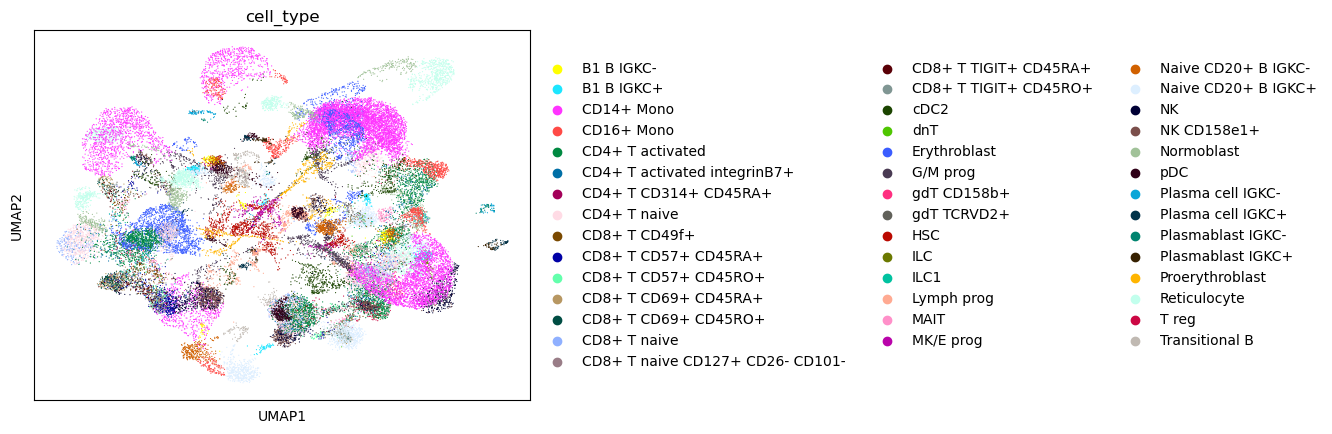

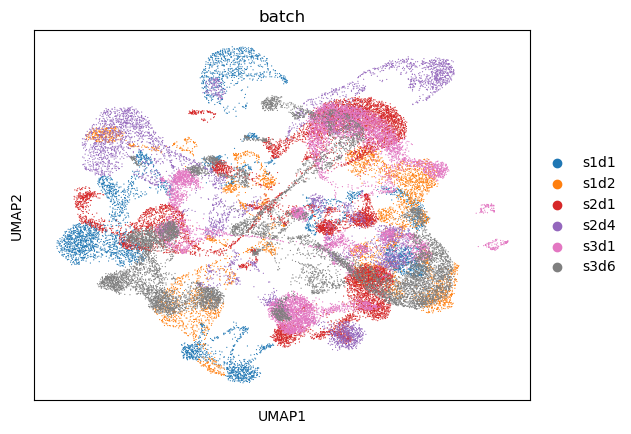

In [12]:
sc.pl.umap(train_gex, color='cell_type')
sc.pl.umap(train_gex, color='batch')

Note, for the `.obs["batch"]` metadata, the symbol represents the site and donor in the following format: `s1d1` for site 1, donor 1.

#### Visualizing ADT

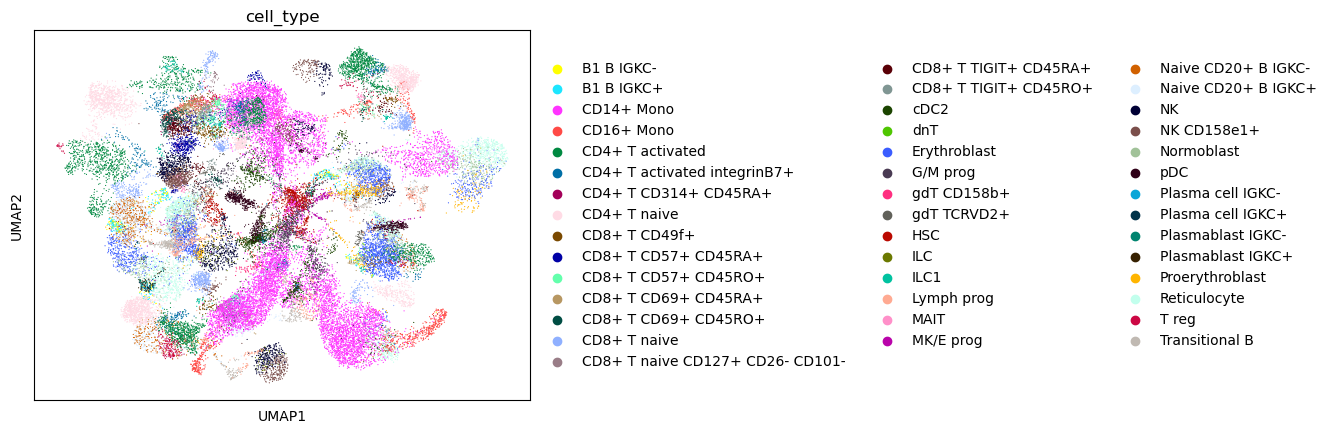

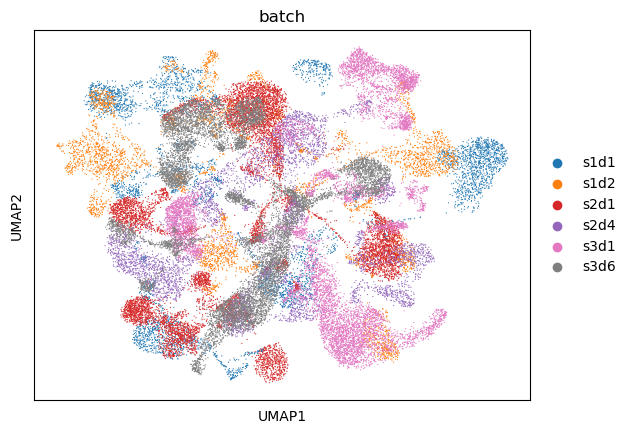

In [13]:
sc.pl.umap(train_adt, color='cell_type')
sc.pl.umap(train_adt, color='batch')

## Simple prediction

Task 1 of the final project is protein Prediction using RNA. Namely, using the RNA expression of one cell to predict the protein abundance in the same cell. 

Simply put, the goal is to take RNA as input and predict the protein. Methods are given some training data in which both RNA and Protein are known, and then a set of cells where only RNA is provided.



For prediction tast, one should expect the following input:
* `input_train_gex`
* `input_train_adt`
* `input_test_gex`

Metrics then expect as input:
* `true_test_adt`
* `pred_test_adt`


In [14]:
# This will get passed to the method
input_train_gex = train_gex
input_train_adt = train_adt
input_test_gex =  test_gex

# This will get passed to the metric
true_test_adt =  test_adt

### RMSE Metric

The metric for prediction is RMSE on the `adata.layers["log_norm"]` data.

In [15]:
def calculate_rmse(true_test_adt, pred_test_adt):
    return  mean_squared_error(true_test_adt.X.toarray(), pred_test_adt.X, squared = False)


### Method

Let's try a method that runs linear regression on PCA transformed data before projecting the data back to the feature space.

In [16]:
def baseline_linear(input_train_gex, input_train_adt, input_test_gex):
    '''Baseline method training a linear regressor on the input data'''
    input_gex = ad.concat(
        {"train": input_train_gex, "test": input_test_gex},
        axis = 0,
        join = "outer",
        label = "group",
        fill_value = 0,
        index_unique = "-", 
    )
    
    # Do PCA on the input data
    logging.info('Performing dimensionality reduction on GEX values...')
    embedder_gex = TruncatedSVD(n_components = 50)
    gex_pca = embedder_gex.fit_transform(input_gex.X)
    

    
    # split dimension reduction GEX back up for training
    X_train = gex_pca[input_gex.obs['group'] == 'train']
    X_test = gex_pca[input_gex.obs['group'] == 'test']
    y_train = input_train_adt.X.toarray()
    
    assert len(X_train) + len(X_test) == len(gex_pca)
    
    logging.info('Running Linear regression...')
    
    reg = LinearRegression()
    
    # Train the model on the PCA reduced gex 1 and 2 data
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    
    # Project the predictions back to the adt feature space
    
    pred_test_adt = ad.AnnData(
        X = y_pred,
        obs = input_test_gex.obs,
        var = input_train_adt.var,
    
    )
    
    # Add the name of the method to the result
    pred_test_adt.uns["method"] = "linear"
    
    return pred_test_adt

Now, for comparison, let's create a simple dummy method that simply returns the mean for the input adt data. This method returns an identical prediction for all cells and ignores the GEX information altogether.

In [17]:
def baseline_mean(input_train_gex, input_train_adt, input_test_gex):
    '''Dummy method that predicts mean(input_train_adt) for all cells'''
    logging.info('Calculate mean of the training data adt...')
    y_pred = np.repeat(input_train_adt.X.mean(axis = 0).reshape(-1, 1).T, input_test_gex.shape[0], axis=0)
    
    # Prepare the ouput data object
    pred_test_adt = ad.AnnData(
        X = y_pred,
        obs = input_test_gex.obs,
        var = input_train_adt.var,
    )
    
    pred_test_adt.uns["method"] = "mean"

    return pred_test_adt

#### Run comparison

Let's run the simple and dummy method side-by-side and compare performance.

In [ ]:
for method in [baseline_linear, baseline_mean]:
    # Run prediction
    pred_test_adt = method(input_train_gex, input_train_adt, input_test_gex)
    # Calculate RMSE
    rmse = calculate_rmse(true_test_adt, pred_test_adt)
    # Print results
    print(f'{pred_test_adt.uns["method"]} had a RMSE of {rmse:.4f}')

INFO:root:Performing dimensionality reduction on GEX values...


As expected, the linear model does better than the dummy method. Now the challenge is up to you! Can you do better than this baseline?